Add necessary libraries

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from torchmetrics.regression import R2Score

We produce a curve to resemble tumour growth, using the Gompertz function, that has a maximum size of 10cm^3 (and a growth rate of 0.18).

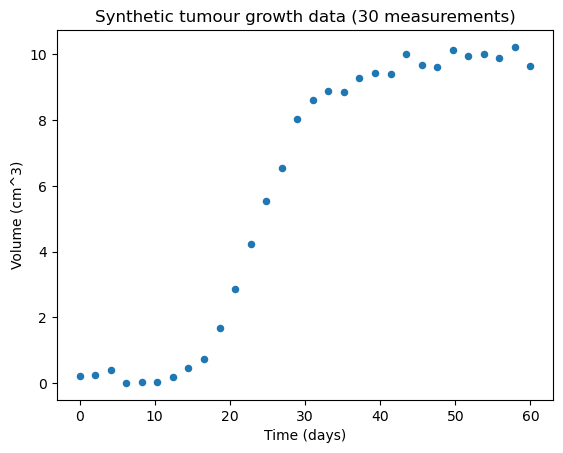

In [40]:
# Creating Synthetic data - we create a sigmoidal curve and increase the noise for each plot

noise = 0.20     # vary the noise level to your choosing
measurements = 30   # vary the number of measurements to your choosing

# Defining a sigmoidal curve
x = np.linspace(0, 60, measurements)
y = (10 * np.exp(-50*np.exp(-0.18*x))) # Gompertz function - maximum size is 10, and growth rate is 0.18

# Adding randomness
noise_level = np.random.normal(0,noise, size=x.shape)  # Gaussian noise
y = abs(y + noise_level)

# Plotting
plt.xlabel("Time (days)") 
plt.ylabel("Volume (cm^3)") 
plt.scatter(x, y, s = 19.5)
plt.title("Synthetic tumour growth data (30 measurements)")
plt.show() 

The PINN is a feed-forward MLP. The loss function is split up into physics loss and data loss, where the total loss is the summation of these. The PINN will output the optimal parameters of the Gompertz DE, a and k which represent the growth rate and maximum size, respectively.

In [41]:
### Inverse PINN - Obtain optimal parameters for Gompertz model

### Gompertz ODE - dV/dt = a*ln(K/V)*V

class TumourGrowthPINN(nn.Module):
    
    # Here we define the NN architecture
    def __init__(self):  
        super(TumourGrowthPINN, self).__init__()
        self.a = nn.Parameter(torch.tensor([1.00]))  # Initial estimate for tumour growth rate (alpha)
        self.k = nn.Parameter(torch.tensor([10.00]))  # # Initial estimate for maximum size (K)
        self.sigmoid_layers = nn.Sequential(
            nn.Linear(1, 128),  # Time input
            nn.Sigmoid(),  # Sigmoid Activation function
            nn.Linear(128, 128),  
            nn.Sigmoid(),   
            nn.Linear(128, 1)  # Volume output
        )
        
        
    # This function passes the data into our neural network - this represents our feed-forward algorithm.
    def forward(self, t):   # 't' represents the time (input), and 'V' represents the volume (output)
        V = self.sigmoid_layers(t)
        return V  # This is our predicted tumour volume V
 
           
    def gompertz_loss(self, t):   # Physics-informed loss, using Gompertz ODE
        V = self.forward(t)
        V_t = torch.autograd.grad(V, t, grad_outputs=V.data.new(V.shape).fill_(1), create_graph=True,
                                  retain_graph=True, allow_unused=True)[0]   # Automatic differentiation
        log_part = torch.log(abs(self.k/V))
        log_part = log_part.float()
        pde_loss = torch.mean((V_t-(self.a*V*log_part))**2) # Gompertz residual
        V0 = self.forward(torch.tensor([0.0]))  # Predicted V at initial time (first data point)
        ic_loss = torch.mean((V0-torch.tensor([0.0]))**2)  # Initial condition loss
        return (0.55 * pde_loss + 0.45 * ic_loss)  # Total physics loss
        
    def total_loss(self, pred_V, V_train, t_train, alpha, beta):  # We combine the physics loss and the data loss
        loss_data = nn.functional.mse_loss(pred_V, V_train)
        loss_physics = self.gompertz_loss(t_train)
        loss_total = alpha * loss_data + beta * loss_physics
        return loss_total
    
        
    def train(self, model, epochs, optimizer, t_train, V_train, alpha, beta):  # Train the model
        for index in range(epochs):
            pred_V = model(t_train)
            loss = self.total_loss(pred_V, V_train, t_train, alpha, beta)
            if index % 500 == 0:
                print(f'Epoch: {index}, Loss: {loss.sum()}')    
            optimizer.zero_grad()
            loss.sum().backward()
            optimizer.step()
        return pred_V    
    
                      
    def predict(self, model, unseen_t):  # Where we pass the validation data
        pred_V = model(unseen_t)    
        return pred_V        

We split the generated data into training and validation data, then use the model to obtain a fit.

In [42]:
# Training on synthetic data

# Splitting into training and validation data
x_train = x
y_train = y
x_valid = []
y_valid = []
while len(x_train) > 21:
    idx = random.randint(1,len(x_train) - 1)
    x_valid = np.append(x_valid, x[idx])
    y_valid = np.append(y_valid, y[idx])
    x_train = np.delete(x_train, idx)
    y_train = np.delete(y_train, idx)


# Converting into tensors for NN usage 
x_train_tensor = torch.tensor(x_train, requires_grad=True)
xx_train = x_train_tensor.unsqueeze(-1)
xx_train = xx_train.float()
y_train_tensor = torch.tensor(y_train, requires_grad=True)
yy_train = y_train_tensor.unsqueeze(-1)
yy_train = yy_train.float()

x_valid_tensor = torch.tensor(x_valid, requires_grad=True)
xx_valid = x_valid_tensor.unsqueeze(-1)
xx_valid = xx_valid.float()
y_valid_tensor = torch.tensor(y_valid, requires_grad=True)
yy_valid = y_valid_tensor.unsqueeze(-1)
yy_valid = yy_valid.float()

# PINN

# Construct model
low_noise_model = TumourGrowthPINN()
optimizer = optim.Adam(low_noise_model.parameters(), lr=0.001)
pinn = low_noise_model.train(low_noise_model, 4500, optimizer, xx_train, yy_train , 0.05, 0.95)
# Prediction
print("\n\nPrediction\n\n")
pred_V = low_noise_model.predict(low_noise_model, xx_valid)
param_a = low_noise_model.a.item()
param_k = low_noise_model.k.item()
print("\n\nOur parameters:\n\n")
print("a (growth rate): ", param_a)
print("k (maximum size): ", param_k)
print("\n\n")
r2score = R2Score()
r2 = r2score(pred_V, yy_valid).float().item()
print("R-squared: ", r2)


Epoch: 0, Loss: 3.2244887351989746
Epoch: 500, Loss: 2.408724784851074
Epoch: 1000, Loss: 1.158700942993164
Epoch: 1500, Loss: 0.006993768271058798
Epoch: 2000, Loss: 0.003195064375177026
Epoch: 2500, Loss: 0.002362607279792428
Epoch: 3000, Loss: 0.0021316497586667538
Epoch: 3500, Loss: 0.002065889537334442
Epoch: 4000, Loss: 0.002038070000708103


Prediction




Our parameters:


a (growth rate):  0.18782959878444672
k (maximum size):  9.930176734924316



R-squared:  0.9975116848945618


0.9975116848945618


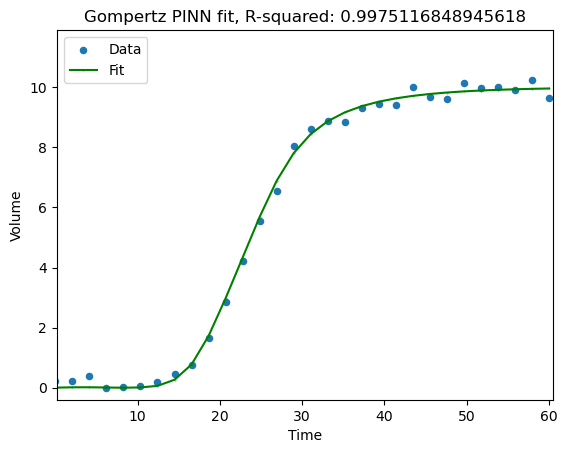

In [43]:
# Plotting predicted volume against actual volume
x_tensor = torch.tensor(x)
xx = x_tensor.unsqueeze(-1)
xx = xx.float()
pinn = low_noise_model(xx)
plt.scatter(x, y, s=19.5)
plt.plot(x, pinn.detach().numpy(), color='green', marker='.', markersize=0.5)
plt.xlabel("Time")
plt.ylabel("Volume")
print(r2) 
r2 = str(r2)
plt.title("Gompertz PINN fit, R-squared: "+ r2)
plt.ylim(-0.4,11.9)
plt.xlim(0.2,60.5)
plt.legend(["Data", "Fit"])
plt.show()

Now we test how the PINN performs when there is much more noise. Note that the more noise we use, the harder the task for the PINN, meaning there may be a few minor fluctuations.

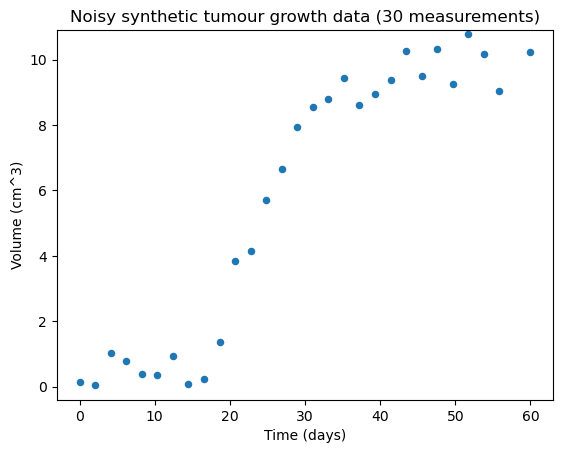

In [47]:
# Same generation as before but with much more noise

noise = 0.6     # vary the noise level to your choosing
measurements = 30   # vary the number of measurements to your choosing

# Defining a sigmoidal curve
x = np.linspace(0, 60, measurements)
y = (10 * np.exp(-50*np.exp(-0.18*x)))

# Adding randomness
noise_level = np.random.normal(0,noise, size=x.shape)  # Gaussian noise
y = abs(y + noise_level)  

# Plotting
plt.xlabel("Time (days)") 
plt.ylabel("Volume (cm^3)") 
plt.scatter(x, y, s = 19.5)
plt.ylim(-0.4,10.9)
plt.title("Noisy synthetic tumour growth data (30 measurements)")
plt.show() 

In [48]:
# Training on synthetic data

# Splitting into training and validation data
x_train = x
y_train = y
x_valid = []
y_valid = []
while len(x_train) > 21:
    idx = random.randint(1,len(x_train) - 1)
    x_valid = np.append(x_valid, x[idx])
    y_valid = np.append(y_valid, y[idx])
    x_train = np.delete(x_train, idx)
    y_train = np.delete(y_train, idx)


# Converting into tensors for NN usage 
x_train_tensor = torch.tensor(x_train, requires_grad=True)
xx_train = x_train_tensor.unsqueeze(-1)
xx_train = xx_train.float()
y_train_tensor = torch.tensor(y_train, requires_grad=True)
yy_train = y_train_tensor.unsqueeze(-1)
yy_train = yy_train.float()

x_valid_tensor = torch.tensor(x_valid, requires_grad=True)
xx_valid = x_valid_tensor.unsqueeze(-1)
xx_valid = xx_valid.float()
y_valid_tensor = torch.tensor(y_valid, requires_grad=True)
yy_valid = y_valid_tensor.unsqueeze(-1)
yy_valid = yy_valid.float()

# PINN

# Construct model
high_noise_model = TumourGrowthPINN()
optimizer = optim.Adam(high_noise_model.parameters(), lr=0.001)
pinn = high_noise_model.train(high_noise_model, 2500, optimizer, xx_train, yy_train , 0.05, 0.95) 
# Prediction
print("\n\nPrediction\n\n")
pred_V = high_noise_model.predict(high_noise_model, xx_valid)
param_a2 = high_noise_model.a.item()
param_k2 = high_noise_model.k.item()
print("\n\nOur parameters:\n\n")
print("a (growth rate): ", param_a2)
print("k (maximum size): ", param_k2)
print("\n\n")
r2score = R2Score()
r2 = r2score(pred_V, yy_valid).float().item()
print("R-squared: ", r2)
r2score(pred_V, yy_valid)

Epoch: 0, Loss: 3.4970645904541016
Epoch: 500, Loss: 2.7671561241149902
Epoch: 1000, Loss: 0.037134572863578796
Epoch: 1500, Loss: 0.02174551412463188
Epoch: 2000, Loss: 0.019182011485099792


Prediction




Our parameters:


a (growth rate):  0.1537495106458664
k (maximum size):  9.852571487426758



R-squared:  0.9893075823783875


tensor(0.9893, grad_fn=<SqueezeBackward0>)

We get a strong R-squared value and the PINN was still able to predict the maximum size and growth rate of the tumour extremely well. Let's visualise this on a two-dimensional plot. The number of epochs may not be optimal, however the resulting fit is desirable.

torch.Size([30, 1])
0.9893075823783875


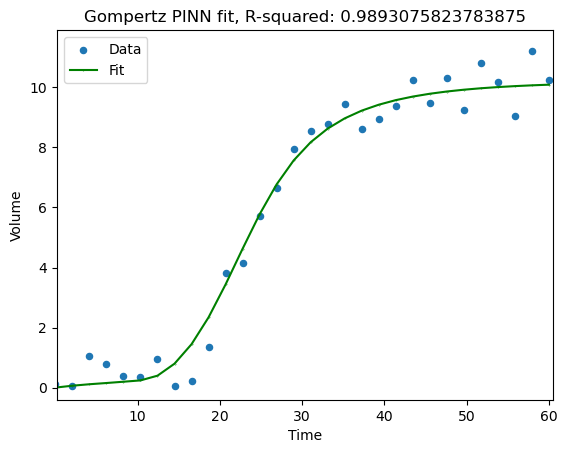

In [49]:
# Plotting predicted volume against actual volume
x_tensor = torch.tensor(x)
xx = x_tensor.unsqueeze(-1)
xx = xx.float()
print(xx.shape)
pinn = high_noise_model(xx)
plt.scatter(x, y, s=19.5)
plt.plot(x, pinn.detach().numpy(), color='green', marker='.', markersize=0.5)
plt.xlabel("Time")
plt.ylabel("Volume")
print(r2)
r2 = str(r2)
plt.title("Gompertz PINN fit, R-squared: "+ r2)
plt.ylim(-0.4,11.9)
plt.xlim(0.2,60.5)
plt.legend(["Data", "Fit"])
plt.show()

Once again, the PINN was still able to predict the maximum size and growth rate of the tumour extremely well, regardless of the noise, portraying the robustness of the PINN. As clinical tumour growth can be quite noisy, PINNs could be very useful.